# 판매준비하기 AB test 분석

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests


# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

Metric 1. 비교견적 신청 전환율


[Click Conversion Rate]


✅ [Click Conversion Rate] Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3970,37448,10.60%
1,B,4251,37696,11.28%
2,C,4259,37682,11.30%
3,D,4256,37460,11.36%



✅ [Click Conversion Rate] Group Conversion Rates
A group conversion rate: 10.60%
B group conversion rate: 11.28%
C group conversion rate: 11.30%
D group conversion rate: 11.36%

✅ [Click Conversion Rate] Chi-square Test
- Chi2 statistic: 14.5537
- p-value: 0.0022

✅ [Click Conversion Rate] Pairwise comparison (Holm-Bonferroni)


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0030,0.0120,True
1,A vs C,0.0021,0.0105,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,1.0000,False
4,B vs D,0.7150,1.0000,False
5,C vs D,0.7987,1.0000,False



✅ [Click Conversion Rate] Pairwise comparison (FDR)


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0030,0.0060,True
1,A vs C,0.0021,0.0060,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,0.9122,False
4,B vs D,0.7150,0.9122,False
5,C vs D,0.7987,0.9122,False


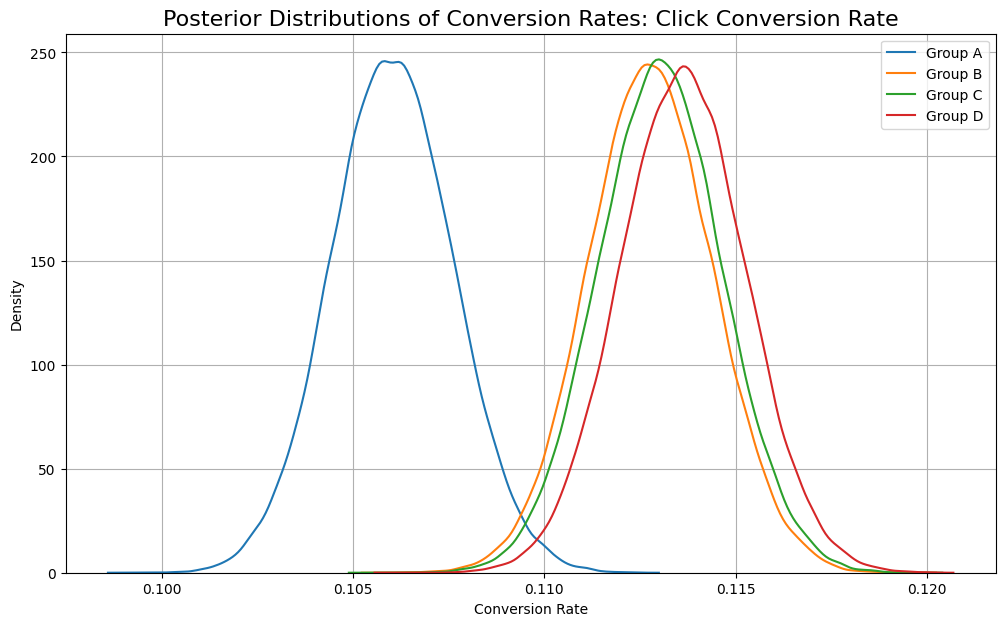


✅ [Click Conversion Rate] Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 24.04%
Probability that C is the best: 29.57%
Probability that D is the best: 46.39%

✅ [Click Conversion Rate] Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0015,0.9985
1,A > C,0.0010,0.9990
2,A > D,0.0004,0.9996
3,B > C,0.4555,0.5445
4,B > D,0.3567,0.6433
5,C > D,0.3979,0.6021



[Purchase Conversion Rate]


✅ [Purchase Conversion Rate] Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,1852,37448,4.95%
1,B,2015,37696,5.35%
2,C,1953,37682,5.18%
3,D,2031,37460,5.42%



✅ [Purchase Conversion Rate] Group Conversion Rates
A group conversion rate: 4.95%
B group conversion rate: 5.35%
C group conversion rate: 5.18%
D group conversion rate: 5.42%

✅ [Purchase Conversion Rate] Chi-square Test
- Chi2 statistic: 10.0760
- p-value: 0.0179

✅ [Purchase Conversion Rate] Pairwise comparison (Holm-Bonferroni)


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0131,0.0656,False
1,A vs C,0.1380,0.5520,False
2,A vs D,0.0033,0.0197,True
3,B vs C,0.3177,0.6354,False
4,B vs D,0.6427,0.6427,False
5,C vs D,0.1439,0.5520,False



✅ [Purchase Conversion Rate] Pairwise comparison (FDR)


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0131,0.0393,True
1,A vs C,0.1380,0.2158,False
2,A vs D,0.0033,0.0197,True
3,B vs C,0.3177,0.3812,False
4,B vs D,0.6427,0.6427,False
5,C vs D,0.1439,0.2158,False


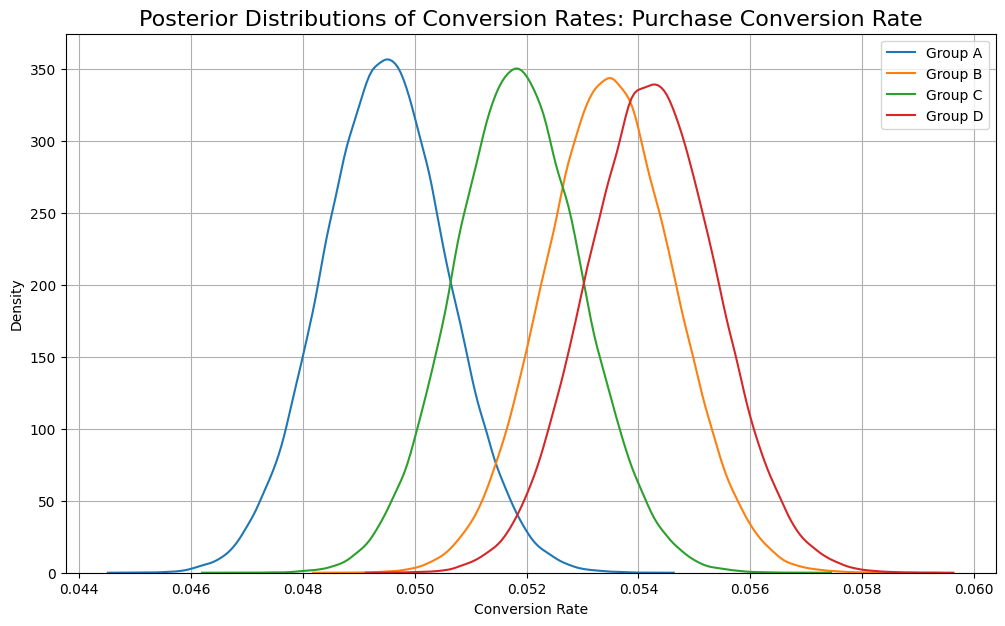


✅ [Purchase Conversion Rate] Bayesian: Probability that each group is best
Probability that A is the best: 0.03%
Probability that B is the best: 30.73%
Probability that C is the best: 3.50%
Probability that D is the best: 65.74%

✅ [Purchase Conversion Rate] Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0065,0.9935
1,A > C,0.0678,0.9322
2,A > D,0.0015,0.9985
3,B > C,0.8408,0.1592
4,B > D,0.3212,0.6788
5,C > D,0.0721,0.9279


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

pd.set_option('display.float_format', '{:.4f}'.format)

def abtest_stats(groups, successes, trials, metric_name="AB Test Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    print(f"\n{'='*60}")
    print( f"[{metric_name}]" )
    print(f"\n{'='*60}")
    print(f"\n✅ [{metric_name}] Group Summary (Successes, Trials, Conversion Rate)")
    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    display(group_summary)

    print(f"\n✅ [{metric_name}] Group Conversion Rates")
    for grp, rate in zip(groups, conversion_rates):
        print(f"{grp} group conversion rate: {rate:.2%}")

    # Chi-square test
    contingency_table = np.array([successes, failures]).T
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"\n{'='*60}\n✅ [{metric_name}] Chi-square Test")
    print(f"- Chi2 statistic: {chi2:.4f}")
    print(f"- p-value: {p_value:.4f}")

    # Pairwise z-test (Holm)
    pairwise_results, pairs = [], []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            count = np.array([successes[i], successes[j]])
            nobs = np.array([trials[i], trials[j]])
            _, p = proportions_ztest(count, nobs)
            pairwise_results.append(p)
            pairs.append(f"{groups[i]} vs {groups[j]}")
    reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
    results_df = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (Holm)': pvals_corrected,
        'Significant': reject
    })
    print(f"\n{'='*60}\n✅ [{metric_name}] Pairwise comparison (Holm-Bonferroni)")
    display(results_df)

    # Pairwise z-test (FDR)
    reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
    results_df_fdr = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (FDR)': pvals_fdr_corrected,
        'Significant (FDR)': reject_fdr
    })
    print(f"\n{'='*60}\n✅ [{metric_name}] Pairwise comparison (FDR)")
    display(results_df_fdr)

    # Bayesian posterior samples
    posterior_samples = {
        g: np.random.beta(1 + s, 1 + f, samples)
        for g, s, f in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for g in groups:
        sns.kdeplot(posterior_samples[g], label=f'Group {g}')
    plt.title(f'Posterior Distributions of Conversion Rates: {metric_name}', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bayesian: Best group probabilities
    best_group_count = {g: 0 for g in groups}
    for i in range(samples):
        best = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best] += 1

    print(f"\n✅ [{metric_name}] Bayesian: Probability that each group is best")
    for g, c in best_group_count.items():
        print(f"Probability that {g} is the best: {c / samples:.2%}")

    # Bayesian: Pairwise superiority
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })

    df_bayes = pd.DataFrame(pairwise_bayes)
    print(f"\n{'='*60}\n✅ [{metric_name}] Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)

# =====================
# 사용 예시 (지표별로 계속 재사용)

groups = ['A', 'B', 'C', 'D']

# 첫 번째 지표 (예: 클릭전환율)
successes1 = np.array([3970, 4251, 4259, 4256])
trials1    = np.array([37448, 37696, 37682, 37460])
abtest_stats(groups, successes1, trials1, metric_name="Click Conversion Rate")

# 두 번째 지표 (예: 구매전환율)
successes2 = np.array([1852, 2015, 1953, 2031])
trials2    = np.array([37448, 37696, 37682, 37460])
abtest_stats(groups, successes2, trials2, metric_name="Purchase Conversion Rate")




In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

def ab_group_test(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    # ✅ metric_name 최상단 출력 (큰 제목)
    print("\n" + "#"*70)
    print(f"📊 {metric_name}\n" + "#"*70)
    
    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    # for grp, rate in zip(groups, conversion_rates):
    #     print(f"{grp} group conversion rate: {rate:.2%}")

    # Chi-square test
    contingency_table = np.array([successes, failures]).T
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print("\n✅ Chi-square Test")
    print(f"- Chi2 statistic: {chi2:.4f}")
    print(f"- p-value: {p_value:.4f}")
    print(f"\n{'='*60}")

    # Pairwise Z-test (Holm-Bonferroni)
    pairwise_results, pairs = [], []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            count = np.array([successes[i], successes[j]])
            nobs = np.array([trials[i], trials[j]])
            _, p = proportions_ztest(count, nobs)
            pairwise_results.append(p)
            pairs.append(f"{groups[i]} vs {groups[j]}")

    reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
    results_df = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (Holm)': pvals_corrected,
        'Significant': reject
    })
    print("\n✅ Pairwise Z-test (Holm-Bonferroni):")
    display(results_df)
    print(f"\n{'='*60}")

    # Pairwise Z-test (FDR)
    reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
    results_df_fdr = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (FDR)': pvals_fdr_corrected,
        'Significant (FDR)': reject_fdr
    })
    print("\n✅ Pairwise Z-test (FDR - Benjamini-Hochberg):")
    display(results_df_fdr)
    print(f"\n{'='*60}")

    # Bayesian analysis
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)
        for group, success, fail in zip(groups, successes, failures)
    }

    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")

    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n✅ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # Bayesian pairwise superiority
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n✅ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")



######################################################################
📊 Estimate Conversion Rate
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3970,37448,10.60%
1,B,4251,37696,11.28%
2,C,4259,37682,11.30%
3,D,4256,37460,11.36%




✅ Chi-square Test
- Chi2 statistic: 14.5537
- p-value: 0.0022


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0030,0.0120,True
1,A vs C,0.0021,0.0105,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,1.0000,False
4,B vs D,0.7150,1.0000,False
5,C vs D,0.7987,1.0000,False




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0030,0.0060,True
1,A vs C,0.0021,0.0060,True
2,A vs D,0.0009,0.0053,True
3,B vs C,0.9122,0.9122,False
4,B vs D,0.7150,0.9122,False
5,C vs D,0.7987,0.9122,False


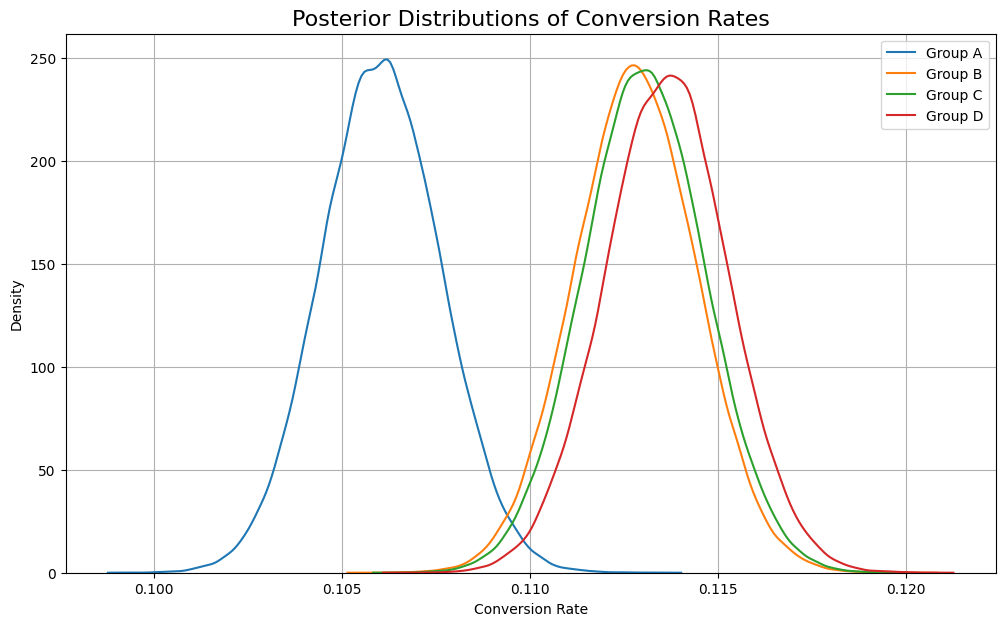



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 24.35%
Probability that C is the best: 29.53%
Probability that D is the best: 46.11%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0016,0.9984
1,A > C,0.0011,0.9989
2,A > D,0.0005,0.9995
3,B > C,0.4585,0.5415
4,B > D,0.3602,0.6398
5,C > D,0.3984,0.6016


In [5]:
groups = ['A', 'B', 'C', 'D']
successes = np.array([3970, 4251, 4259, 4256])
trials = np.array([37448, 37696, 37682, 37460])

ab_group_test(groups, successes, trials, metric_name="Estimate Conversion Rate")
